In [104]:
policies = [
    "adaptive_greedy_percentile",
    "adaptive_greedy_weighted",
    "bootstrapped_ts",
    "separate_classifiers",
    "softmax_explorer",
    "epsilon_greedy_decay",
    "epsilon_greedy",
    "bootstrapped_ucb"
]

traces = [
    "att.lte.driving.2016",
    "tm.lte.driving",
    "vz.lte.driving"
]

iperf_dir = "/home/lorenzo/Desktop/mimic-2/log/iperf"

In [105]:
import os
from datetime import datetime
TIME_FORMAT = '%Y.%m.%d.%H.%M.%S'
last_ts = None
iperf_dict = {}
for p in policies:
    iperf_dict[p] = {}
    for t in traces:
        flag = False
        for file in os.listdir(iperf_dir):
            if file.startswith(f"{t}.{p}"):
                ts = datetime.strptime(".".join(file.split(".")[-7:][:6]), TIME_FORMAT)
                if not flag:
                    flag = True
                    last_ts = ts
                if ts > last_ts:
                    last_ts = ts
        iperf_dict[p][t] = f"{t}.{p}.{datetime.strftime(last_ts, TIME_FORMAT)}.json"

In [106]:
iperf_dict["bootstrapped_ucb"]["att.lte.driving.2016"] = "att.lte.driving.2016.bootstrapped_ucb.2023.05.22.00.04.03.json"

In [107]:
import json
def read_json_file(file_path):
    with open(file_path, 'r') as json_file:
        data = json.load(json_file)
        return data
    
def get_metrics(config):
    rtts = []
    cwnds = [] 
    s_rate = []
    for intervals in config['intervals']:
        s_rate.append(intervals['streams'][0]['bits_per_second']*10**(-6))
        cwnds.append(intervals['streams'][0]['snd_cwnd'])
        rtts.append(intervals['streams'][0]['rtt']*10**(-3))
    thruput = config["end"]["streams"][0]["receiver"]["bits_per_second"]*10**(-6)
    return thruput, rtts, cwnds, s_rate

In [108]:
import json
iperf_trace = {}
for p in policies:
    iperf_trace[p] = {}
    for t in traces:
        with open(os.path.join(iperf_dir, iperf_dict[p][t]), "r") as f:
            iperf_trace[p][t] = json.load(f)

In [109]:
import yaml
# Open the YAML file
with open("/home/lorenzo/Desktop/mimic-2/config/models.yml", "r") as f:
    models_yaml = yaml.load(f, Loader=yaml.FullLoader)

In [110]:
# i_json_5_arms = {
#     "att.lte.driving.2016": "att.lte.driving.2016.bootstrapped_ucb.2023.05.22.00.04.03.json",
#     "tm.lte.driving": "tm.lte.driving.bootstrapped_ucb.2023.05.22.00.05.15.json",
#     "vz.lte.driving": "vz.lte.driving.bootstrapped_ucb.2023.05.22.00.06.19.json"
# }

# for t in traces:
#     iperf_trace["bootstrapped_ucb"][t] = read_json_file(os.path.join(iperf_dir, i_json_5_arms[t]))

In [111]:
FIGSIZE_X = 8.6
FIGSIZE_Y = 7
X_LABEL_SIZE = 22
Y_LABEL_SIZE = 22
X_TICKS_SIZE = 20
Y_TICKS_SIZE = 20
LEGEND_SIZE = 24
LINEWIDTH = 2.5
MARKERSIZE = 18

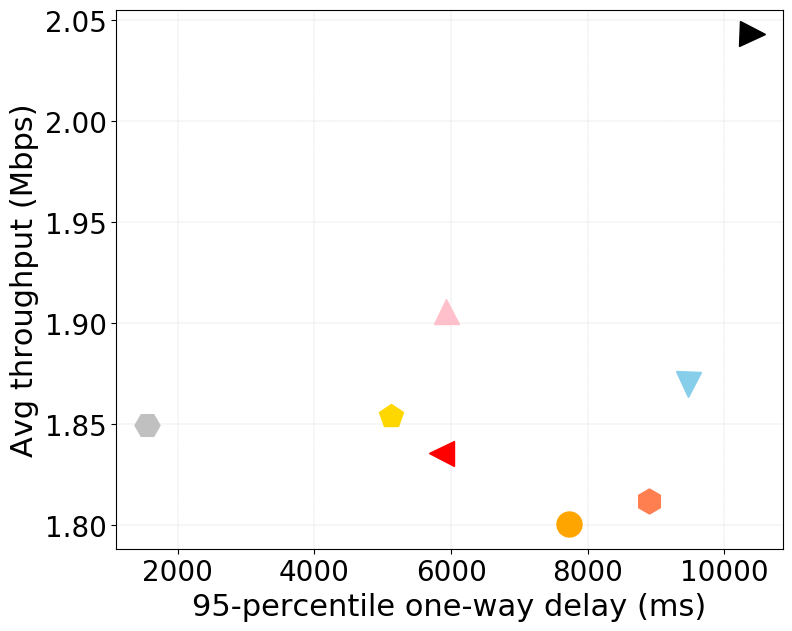

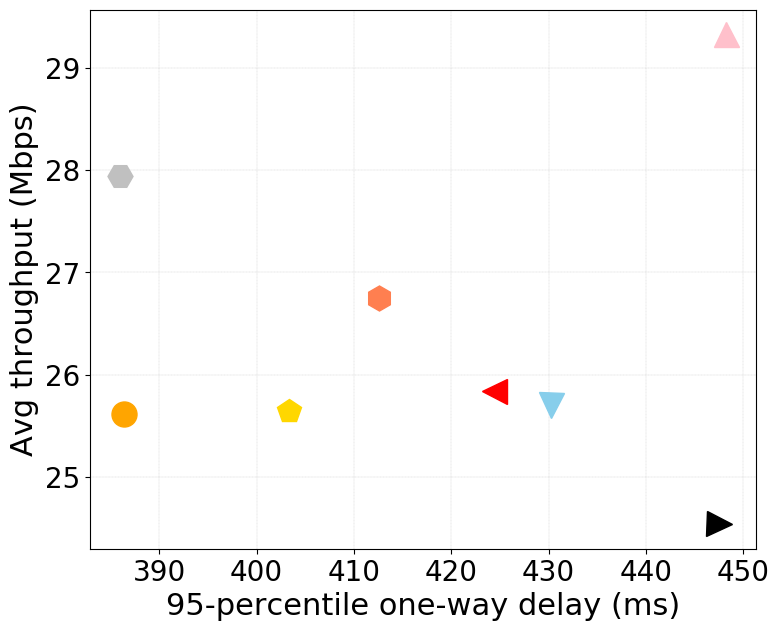

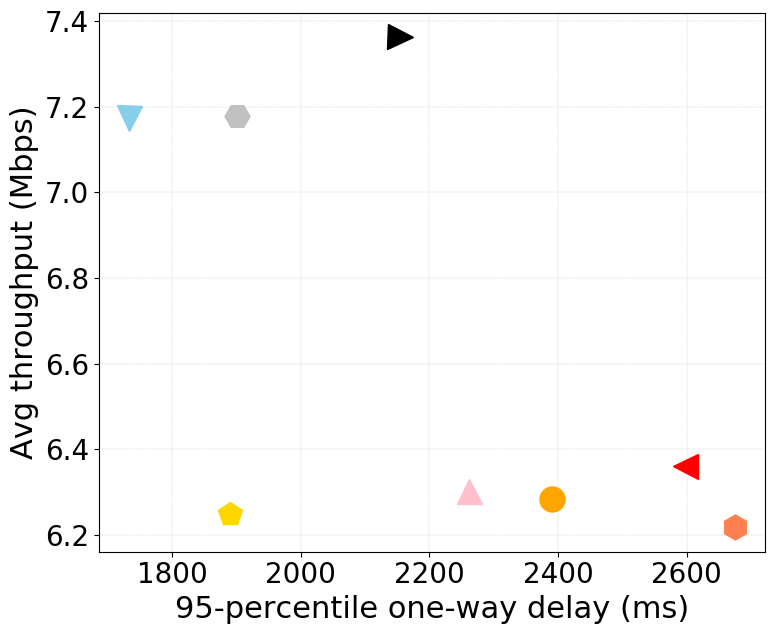

In [112]:
save = True
import matplotlib.pyplot as plt
import numpy as np

for t in traces:
    fig, ax = plt.subplots(figsize=(FIGSIZE_X, FIGSIZE_Y))
    for p in policies:
        marker = models_yaml["models"][p]["marker"]
        color = models_yaml["models"][p]["color"]
        # Get mimic config
        config = iperf_trace[p][t]
        # Get metrics
        metrics_receiver = config['end']['streams'][0]['receiver']
        metrics_sender = config['end']['streams'][0]['sender']
        #  Get latency
        thruput, rtts, _, _ = get_metrics(config)
        # one-way delay
        delay_95_perc = np.percentile(rtts, 95)/2

        # Plot
        ax.plot(delay_95_perc, thruput, 
                marker=marker, label=p, 
                markersize=MARKERSIZE, linestyle="None", color=color)

    # set axis labels and legend
    # ax.set_title(t)
    plt.rc('xtick', labelsize=X_TICKS_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=Y_TICKS_SIZE)    # fontsize of the tick labels
    ax.set_xlabel('95-percentile one-way delay (ms)', fontsize=X_LABEL_SIZE)
    ax.set_ylabel('Avg throughput (Mbps)', fontsize=Y_LABEL_SIZE)
    # lgd=ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13),
    #       ncol=2, fancybox=True, shadow=True, fontsize=14)
    plt.grid(linestyle='--', linewidth=0.2)

    if save:
        filename = f"mab.{p}.{t}.thruput_vs_95-perc_delay_baselines.png"
        plt.savefig(os.path.join("/home/lorenzo/Desktop/mimic-2/analysis/plots/policies", 
                                 filename))

    # show plot
    plt.show()

In [119]:
import matplotlib.pyplot as plt

# Define the models dictionary
models = {
    'adaptive_greedy_percentile': {'name': 'Adaptive Greedy Percentile', 'marker': 'h', 'color': 'coral'},
    'adaptive_greedy_weighted': {'name': 'Adaptive Greedy Weighted', 'marker': '^', 'color': 'pink'},
    'bootstrapped_ts': {'name': 'Bootstrapped Thompson Sampling', 'marker': '<', 'color': 'red'},
    'bootstrapped_ucb': {'name': 'Bootstrapped Upper Confidence Bound', 'marker': '>', 'color': 'black'},
    'epsilon_greedy_decay': {'name': 'Epsilon Greedy Decay', 'marker': 'H', 'color': 'silver'},
    'epsilon_greedy': {'name': 'Epsilon Greedy', 'marker': 'p', 'color': 'gold'},
    'separate_classifiers': {'name': 'Separate Classifier', 'marker': 'v', 'color': 'skyblue'},
    'softmax_explorer': {'name': 'Softmax Explorer', 'marker': 'o', 'color': 'orange'}
}

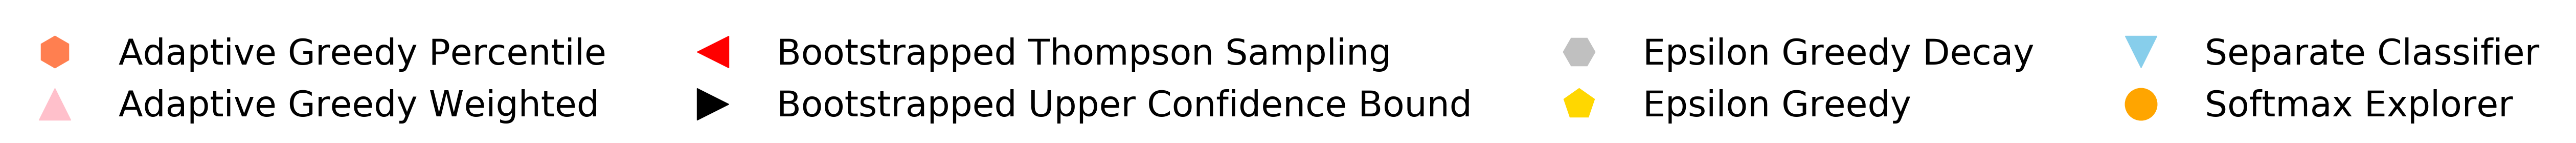

In [120]:
    
# Create a figure and axis
fig, ax = plt.subplots(figsize=(30,1))

# Draw dummy plots for legend
for model, properties in models.items():
    ax.plot([], [], label=properties['name'], marker=properties['marker'],
            markersize=45, linestyle='', color=properties["color"])


# Create the legend horizontally in one row
ax.legend(ncol=int(len(models)/2), frameon=False, fontsize=50)

# Hide the axis
ax.axis('off')

plt.savefig("/home/lorenzo/Desktop/mimic-2/analysis/plots/policies/legend.png", bbox_inches='tight',dpi=300)

# Show the plot
plt.show()